# Transfer learning - Cats vs. Dogs

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os

**[TODO] Create a data loader function that returns a tuple with a tf.float32 tensor for the image and a label. Images must be resized to 128x128.**
**N.B.: filenames are formatted as class.number.jpg**

In [2]:
def load_image(img_path, resize_to=None):
    # read the image from disk, decode it, convert the data type to
    # floating point, and resize it
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    if resize_to is not None:
        image = tf.image.resize(image, resize_to, method=tf.image.ResizeMethod.AREA)
        # image = tf.image.resize_with_crop_or_pad(image, resize_to)
    # parse the class label from the file path
    fn_img = tf.strings.split(img_path, sep='/')[-1]
    label = tf.strings.split(fn_img, sep='.')[0]
    label = tf.strings.to_number(label, tf.float32)

    # return the image and the label
    return image, label


def load_dataset(folder):
    features_list = []
    labels_list = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            filepath = os.path.join(folder, filename)
            features, label = load_image(filepath, resize_to=(128, 128))
            features_list.append(features)
            labels_list.append(label)
    ds_features = tf.data.Dataset.from_tensor_slices(features_list)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels_list)
    return tf.data.Dataset.zip((ds_features, ds_labels))

**[TODO] Create a tf.Dataset, map the loader function and prepare a batch object for training**

In [3]:
# Datasets creation
# 0 -> cats; 1 -> dogs
ds_train = load_dataset('./train/')
ds_test = load_dataset('./test/')

In [4]:
# Batch preparation
ds_train = ds_train.batch(batch_size=64)
# ds_train = ds_train.shuffle(128)
ds_test = ds_test.batch(batch_size=64)
# ds_test = ds_test.shuffle(128)

**Prepare Keras callback for Tensorboard**

In [22]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, update_freq='batch')

**[TODO] Import the MobileNetV2 model trained on ImageNet without the final layer**

In [5]:
mnv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(128, 128, 3), include_top=False, classes=2)
mnv2.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


**[TODO] Add a final classification layer for 2 classes and create the final Keras model**

In [6]:
inputs = tf.keras.Input(shape=(128, 128, 3))
h = mnv2(inputs, training=False)
# h = tf.keras.layers.GlobalAveragePooling2D()(h)
h = tf.keras.layers.Flatten()(h)
# h = tf.keras.layers.Dropout(0.2)(h)
classifier = tf.keras.layers.Dense(2, activation='softmax')(h)

**[TODO] Compile the Keras model: specify the optimization algorithm, the loss function and the test metric**

In [7]:
model = tf.keras.Model(inputs=inputs, outputs=classifier)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**[TODO] Train the Keras model**

In [8]:
model.fit(ds_train, epochs=6)

Epoch 1/10
32/32 [==============================] - 6s 50ms/step - loss: 97.7419 - accuracy: 0.7705
Epoch 2/10
32/32 [==============================] - 1s 39ms/step - loss: 246.2863 - accuracy: 0.4870
Epoch 3/10
32/32 [==============================] - 1s 39ms/step - loss: 15.2428 - accuracy: 0.9245
Epoch 4/10
32/32 [==============================] - 1s 39ms/step - loss: 5.0903 - accuracy: 0.9620
Epoch 5/10
32/32 [==============================] - 1s 39ms/step - loss: 4.1320 - accuracy: 0.9635
Epoch 6/10
32/32 [==============================] - 1s 40ms/step - loss: 2.5059 - accuracy: 0.9775
Epoch 7/10
32/32 [==============================] - 1s 41ms/step - loss: 1.2270 - accuracy: 0.9910
Epoch 8/10
32/32 [==============================] - 1s 41ms/step - loss: 0.8561 - accuracy: 0.9945
Epoch 9/10
32/32 [==============================] - 1s 41ms/step - loss: 0.6324 - accuracy: 0.9955
Epoch 10/10
32/32 [==============================] - 1s 42ms/step - loss: 0.4713 - accuracy: 0.9960


**[TODO] Print model summary**

In [9]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 2)                 40962     
                                                                 
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________
None


**[TODO] Test the Keras model by computing the accuracy the whole test set**

In [10]:
model.evaluate(ds_test)

16/16 [==============================] - 2s 64ms/step - loss: 3.8360 - accuracy: 0.9660


[3.835981607437134, 0.9660000205039978]

**[TODO] Load Test image 'test/0.1047.jpg', visualize it and check the network prediction**

1/1 [==============================] - 1s 1s/step


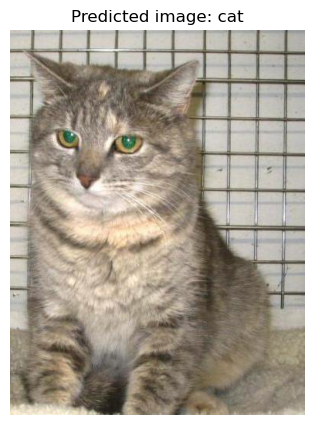

In [16]:
# Showing the image
img_class = 0
img_number = 1047  # Test images are in range 1001 -> 1500
data, label = load_image(f'./test/{img_class}.{img_number}.jpg', resize_to=(128, 128))
# data, label = load_image('./test/0.1047.jpg', resize_to=(128, 128))
data_show, _ = load_image(f'./test/{img_class}.{img_number}.jpg')
# data_show, _ = load_image('./test/0.1047.jpg')
plt.figure(figsize=(5, 5))
plt.imshow(data_show)
ds_img_data = tf.data.Dataset.from_tensor_slices([data])
oh_label = model.predict(ds_img_data.batch(16))
y_hat = np.argmax(oh_label)
c = ['cat', 'dog']
plt.title(f'Predicted image: {c[y_hat]}')
plt.axis('off')
plt.show()